# Importing libraries


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 
from tensorflow import keras
from tensorflow.keras import models
import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Loading dataset

In [2]:
(x_train,y_train) , (x_test ,y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = x_train[:10000,:,:]
x_test = x_test[:1000,:,:]
y_train = y_train[:10000]
y_test  = y_test[:1000]

print(len(x_train), len(x_test))


10000 1000


# showing a sample of the data 

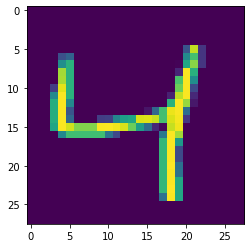

In [4]:
plt.imshow(x_train[2])
plt.show()

# split the image into grids

In [5]:
def blockshaped(arr, nrows, ncols):
    h, w = arr.shape
    grid = (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))
    return grid
    

# get the centroid for each grid

In [6]:
def centroid(grid):
    Mx = 0
    My = 0
    mass = 0
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if grid[i][j]:
                Mx += j
                My += i
                mass += 1
        if mass==0:
            mass=1
    point = (float(Mx)/mass , float(My)/mass)
    return point

In [7]:
cols=7

# Applying the functions on training data

In [8]:
train_vector= []

In [9]:
for pic in x_train:
    grid=blockshaped(pic,cols ,cols)
    train_vector.append([centroid(x) for x in grid])

In [10]:
train_vector=np.array(train_vector)

In [11]:
train_vector=train_vector.reshape(10000,len(train_vector[0])*2,1)
train_vector.shape

(10000, 32, 1)

# Applying the functions on testing data

In [12]:
test_vector= []

In [13]:
for pic in x_test:
    grid=blockshaped(pic, cols , cols)
    test_vector.append([centroid(x) for x in grid])

In [14]:
test_vector=np.array(test_vector)

In [15]:
test_vector=test_vector.reshape(1000,len(test_vector[0])*2,1)
test_vector.shape

(1000, 32, 1)

# apply one hot encoder representation 


In [16]:
train_label = np.zeros((10000, 10,1))
for col in range (10000):
    val=y_train[col]
    for row in range (10):
        if (val==row):
            train_label[col][row]=1

print("train_data shape="+str(np.shape(train_vector)))
print("train_label shape="+str(np.shape(train_label)))

train_data shape=(10000, 32, 1)
train_label shape=(10000, 10, 1)


In [17]:
test_label = np.zeros((1000, 10,1))
for col in range (1000):
    val=y_test[col]
    for row in range (10):
        if (val==row):
            test_label[col,val]=1
print("test_data shape="+str(np.shape(test_vector)))
print("test_label shape="+str(np.shape(test_label)))

test_data shape=(1000, 32, 1)
test_label shape=(1000, 10, 1)


# apply NN

In [18]:
def init_params(no_neurons_h1,no_neurons_h2,output_layer):
    W1 = np.random.randn(no_neurons_h1, len(train_vector[0])) 
    W2 = np.random.randn(no_neurons_h2, len(W1)) 
    W3 = np.random.randn(output_layer, len(W2)) 
    return W1, W2,W3

def sigmoid(Z):
    return  1/(1 + np.exp(-Z))

def normalization(x):
    sum=0
    for i in range(len(x)):
        sum+=x[i]
    for i in range(len(x)):
        x[i]=x[i]/sum
    return x

def MSE(actual,predicted):
    sum = 0  
    n = len(actual) 
    for i in range (0,n):  
        difference = actual[i] - predicted[i]  
        squared_difference = difference**2  
        sum = sum + squared_difference  
    MSE = sum/n  
    return MSE
def get_index(x):
    index=0
    max=x[0]
    for i in range(10):
        if max<x[i]:
            max=x[i]
            index=i
    return index
        
def forward_prop(W1, W2, W3,X):
    #hidden layer1
    Z1=W1.dot(X)
    A1 = sigmoid(Z1)
    
    #hidden layer2
    Z2 = W2.dot(A1)
    A2 = sigmoid(Z2)
    
    #output layer
    Z3 = W3.dot(A2)
    A3 = sigmoid(Z3)
    A3=normalization(A3)
    return Z1, A1, Z2, A2,Z3,A3

def sigmoid_deriv(z):
    return sigmoid(z)*(1-sigmoid(z))


def backward_prop(Z1, A1, Z2, A2,Z3, A3, W1, W2,W3,alpha, X, train_label):
    
    #output layer
    error=train_label-A3
    dZ3 = error*sigmoid_deriv(Z3)
    dW3 = alpha* dZ3.dot(A2.T)
    
    #hidden layer 2
    dZ2 = W3.T.dot(dZ3) * sigmoid_deriv(Z2)
    dW2 = alpha * dZ2.dot(A1.T)

    #hidden layer 1
    dZ1 = W2.T.dot(dZ2) * sigmoid_deriv(Z1)    
    dW1 = alpha * dZ1.dot(X.T)
    
    return dW1,dW2,dW3

def update_params(W1,  W2,W3 , dW1, dW2,dW3, alpha):
    W1 = W1+dW1
    W2 = W2+dW2
    W3 = W3+dW3  
    return W1,W2,W3

In [19]:
def make_predictions(X, W1,W2,W3):
    _, _, _,_,_, A3 = forward_prop(W1,W2,W3, X)
    return A3

def get_accuracy(actual, predicted1):
    correct = 0
    predicted=[]
    for i in range(len(predicted1)):
        x=get_index(predicted1[i])
        predicted.append(x)
        
    for i in range(len(predicted)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def training_fit(X, Y, neurons_h1,neurons_h2,alpha,iterations):
    W1, W2,W3 = init_params(neurons_h1,neurons_h2,10)
    actual=[]
    
    for i in range(len(Y)):
        x=get_index(Y[i])
        actual.append(x)
    
    for j in range(iterations):
        print("Iteration: ",j)
        predictions=[]
        error=0
        for i in range(len(X)):
            Z1, A1, Z2, A2,Z3, A3 = forward_prop(W1,W2,W3, X[i])
            error+=MSE(A3,Y[i])
            dW1, dW2,dW3= backward_prop(Z1, A1, Z2, A2, Z3, A3,W1,W2,W3, alpha,X[i], Y[i])
            W1, W2,W3 = update_params(W1, W2,W3,dW1,dW2,dW3, alpha)
            predictions.append(make_predictions(X[i],W1, W2,W3))
        print("Error: ",error/len(X))
        print("Training Accuracy: ",get_accuracy(actual,predictions)," %")
    return W1, W2,W3

In [20]:
X_train=train_vector[:10000,:]
Y_train=train_label[:10000,:]
X_test=test_vector[:1000,:]
Y_test=test_label[:1000,:]
neurons_h1=45
neurons_h2=24
weight1,weight2,weight3= training_fit(X_train,Y_train,neurons_h1,neurons_h2,0.01,100)

Iteration:  0
Error:  [0.09135724]
Training Accuracy:  4.16  %
Iteration:  1
Error:  [0.08691576]
Training Accuracy:  6.3100000000000005  %
Iteration:  2
Error:  [0.08478692]
Training Accuracy:  7.6499999999999995  %
Iteration:  3
Error:  [0.08160976]
Training Accuracy:  24.86  %
Iteration:  4
Error:  [0.07057293]
Training Accuracy:  57.11000000000001  %
Iteration:  5
Error:  [0.06377292]
Training Accuracy:  63.690000000000005  %
Iteration:  6
Error:  [0.05904977]
Training Accuracy:  66.9  %
Iteration:  7
Error:  [0.05513794]
Training Accuracy:  69.3  %
Iteration:  8
Error:  [0.05180897]
Training Accuracy:  71.3  %
Iteration:  9
Error:  [0.04889089]
Training Accuracy:  73.49  %
Iteration:  10
Error:  [0.04621846]
Training Accuracy:  75.27000000000001  %
Iteration:  11
Error:  [0.04371408]
Training Accuracy:  76.97  %
Iteration:  12
Error:  [0.04147694]
Training Accuracy:  78.0  %
Iteration:  13
Error:  [0.03953492]
Training Accuracy:  79.33  %
Iteration:  14
Error:  [0.03782601]
Traini

# testing the accuracy

In [21]:
actual=[]

for i in range(len(Y_test)):
    x=get_index(Y_test[i])
    actual.append(x)
    
predictions=[]
for i in range(len(X_test)):
    A3=make_predictions(X_test[i], weight1,weight2,weight3)
    predictions.append(A3)

print("Test Accuracy: ",get_accuracy(actual,predictions)," %")

Test Accuracy:  83.8  %


In [22]:
y=[]
for i in range(len(predictions)):
    x=get_index(predictions[i])
    y.append(x)
for i in range(len(y)):
    print(actual[i],"",y[i])

7  7
2  2
1  1
0  0
4  4
1  1
4  4
9  4
5  5
9  9
0  0
6  6
9  9
0  0
1  1
5  6
9  9
7  7
3  6
4  4
9  9
6  6
6  6
5  5
4  4
0  0
7  7
4  4
0  0
1  1
3  3
1  1
3  3
4  4
7  7
2  2
7  7
1  1
2  2
1  1
1  1
7  7
4  4
2  2
3  3
5  8
1  1
2  2
4  4
4  4
6  6
3  3
5  5
5  5
6  6
0  0
4  4
1  1
9  9
5  5
7  7
8  8
9  9
3  3
7  7
4  4
6  6
4  4
3  3
0  0
7  7
0  0
2  2
9  7
1  1
7  7
3  3
2  2
9  1
7  7
7  9
6  6
2  2
7  7
8  5
4  4
7  7
3  3
6  6
1  1
3  3
6  6
9  9
3  3
1  1
4  4
1  4
7  4
6  6
9  9
6  6
0  0
5  5
4  4
9  9
9  9
2  2
1  1
9  9
4  9
8  3
7  7
3  3
9  9
7  7
4  4
4  4
4  4
9  9
2  8
5  3
4  4
7  5
6  6
7  8
9  9
0  0
5  5
8  8
5  5
6  6
6  6
5  5
7  7
8  8
1  1
0  0
1  1
6  6
4  4
6  6
7  7
3  3
1  1
7  7
1  1
8  8
2  2
0  0
2  2
9  9
9  9
5  5
5  0
1  1
5  5
6  6
0  0
3  3
4  3
4  8
6  6
5  5
4  4
6  6
5  5
4  4
5  5
1  1
4  4
4  4
7  3
2  2
3  3
2  2
7  7
1  1
8  8
1  1
8  8
1  1
8  8
5  5
0  0
8  8
9  9
2  2
5  3
0  0
1  1
1  1
1  1
0  0
9  3
0  0
3  7
1  1
6  6
4  4
2  3
